  # CORAL for ST

  Creating something like CellDART but just using coral loss

In [1]:
import argparse
import os
import datetime
from copy import deepcopy
import pickle
import warnings

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import yaml


import torch
from torch.nn import functional as F
from torch import nn

from src.da_models.coral import CORAL
from src.da_models.datasets import SpotDataset
from src.da_models.utils import initialize_weights
from src.utils.dupstdout import DupStdout
from src.utils.data_loading import (
    load_spatial,
    load_sc,
    get_selected_dir,
    get_model_rel_path,
)
from src.utils.evaluation import format_iters, coral_loss

# datetime object containing current date and time
script_start_time = datetime.datetime.now(datetime.timezone.utc)


/tmp/ipykernel_7426/4135859767.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
parser = argparse.ArgumentParser(
    description=(
        "Creating something like CellDART "
        "but it actually follows Adda in PyTorch as a first step"
    )
)
parser.add_argument(
    "--config_fname",
    "-f",
    type=str,
    help="Name of the config file to use",
)
parser.add_argument(
    "--njobs",
    type=int,
    default=0,
    help="Number of jobs to use for parallel processing.",
)
parser.add_argument(
    "--cuda",
    "-c",
    default=None,
    help="gpu index to use",
)


_StoreAction(option_strings=['--cuda', '-c'], dest='cuda', nargs=None, const=None, default=None, type=None, choices=None, help='gpu index to use', metavar=None)

In [3]:
CONFIG_FNAME = "coral.yml"
NUM_WORKERS = 16
CUDA_INDEX = None

# args = parser.parse_args()
# CONFIG_FNAME = args.config_fname
# CUDA_INDEX = args.cuda
# NUM_WORKERS = args.njobs


In [4]:
# torch_params = {}

# torch_params["manual_seed"] = 3583


In [5]:
# data_params = {}
# # Data path and parameters
# data_params["data_dir"] = "data"
# data_params["train_using_all_st_samples"] = False
# data_params["n_markers"] = 20
# data_params["all_genes"] = False

# # Pseudo-spot parameters
# data_params["n_spots"] = 20000
# data_params["n_mix"] = 8

# # ST spot parameters
# data_params["st_split"] = False
# data_params["sample_id_n"] = "151673"

# # Scaler parameter
# data_params["scaler_name"] = "standard"


In [6]:
MODEL_NAME = "CORAL"

# model_params = {}

# # Model parameters

# model_params["model_version"] = "v1"

# model_params["coral_kwargs"] = {
#     "enc_hidden_layer_sizes": (1024, 512, 64),
#     "hidden_act": "leakyrelu",
#     "dropout": 0.5,
#     "batchnorm": True,
#     "batchnorm_after_act": True,
# }


In [7]:
# train_params = {}

# train_params["batch_size"] = 512

# # Pretraining parameters
# # SAMPLE_ID_N = "151673"

# # train_params["initial_train_epochs"] = 100

# # train_params["early_stop_crit"] = 100
# # train_params["min_epochs"] = 0.4 * train_params["initial_train_epochs"]

# # Adversarial training parameters
# train_params["epochs"] = 100
# train_params["early_stop_crit_adv"] = train_params["epochs"]
# train_params["min_epochs_adv"] = 0.4 * train_params["epochs"]


# # train_params["enc_lr"] = 0.0002
# # train_params["alpha"] = 2
# # train_params["dis_loop_factor"] = 5
# # train_params["adam_beta1"] = 0.5
# train_params["lambda"] = 100
# train_params["opt_kwargs"] = {"lr": 0.001, "weight_decay": 0.3}
# train_params["two_step"] = True


In [8]:
# config = {
#     "torch_params": torch_params,
#     "data_params": data_params,
#     "model_params": model_params,
#     "train_params": train_params,
# }

# if not os.path.exists(os.path.join("configs", MODEL_NAME)):
#     os.makedirs(os.path.join("configs", MODEL_NAME))

# with open(os.path.join("configs", MODEL_NAME, CONFIG_FNAME), "w") as f:
#     yaml.safe_dump(config, f)

with open(os.path.join("configs", MODEL_NAME, CONFIG_FNAME), "r") as f:
    config = yaml.safe_load(f)

print(yaml.safe_dump(config))

torch_params = config["torch_params"]
data_params = config["data_params"]
model_params = config["model_params"]
train_params = config["train_params"]


data_params:
  all_genes: false
  data_dir: data
  n_markers: 20
  n_mix: 8
  n_spots: 20000
  sample_id_n: '151673'
  scaler_name: standard
  st_split: false
  train_using_all_st_samples: false
model_params:
  coral_kwargs:
    batchnorm: true
    batchnorm_after_act: true
    dropout: 0.5
    enc_hidden_layer_sizes:
    - 1024
    - 512
    - 64
    hidden_act: leakyrelu
  model_version: v1
torch_params:
  manual_seed: 3583
train_params:
  batch_size: 512
  early_stop_crit_adv: 100
  epochs: 100
  lambda: 100
  min_epochs_adv: 40.0
  opt_kwargs:
    lr: 0.001
    weight_decay: 0.3
  two_step: true



In [9]:
if CUDA_INDEX is not None:
    device = torch.device(f"cuda:{CUDA_INDEX}" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    warnings.warn("Using CPU", stacklevel=2)


In [10]:
if "manual_seed" in torch_params:
    torch_seed = torch_params["manual_seed"]
    torch_seed_path = str(torch_params["manual_seed"])
else:
    torch_seed = int(script_start_time.timestamp())
    # torch_seed_path = script_start_time.strftime("%Y-%m-%d_%Hh%Mm%Ss")
    torch_seed_path = "random"

torch.manual_seed(torch_seed)
np.random.seed(torch_seed)


In [11]:
model_folder = get_model_rel_path(
    MODEL_NAME,
    model_params["model_version"],
    scaler_name=data_params["scaler_name"],
    n_markers=data_params["n_markers"],
    all_genes=data_params["all_genes"],
    n_mix=data_params["n_mix"],
    n_spots=data_params["n_spots"],
    st_split=data_params["st_split"],
    torch_seed_path=torch_seed_path,
)
model_folder = os.path.join("model", model_folder)

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)


  # Data load

In [12]:
selected_dir = get_selected_dir(
    data_params["data_dir"], data_params["n_markers"], data_params["all_genes"]
)

# Load spatial data
mat_sp_d, mat_sp_train, st_sample_id_l = load_spatial(
    selected_dir,
    data_params["scaler_name"],
    train_using_all_st_samples=data_params["train_using_all_st_samples"],
    st_split=data_params["st_split"],
)

# Load sc data
sc_mix_d, lab_mix_d, sc_sub_dict, sc_sub_dict2 = load_sc(
    selected_dir,
    data_params["scaler_name"],
    n_mix=data_params["n_mix"],
    n_spots=data_params["n_spots"],
)


  # Training: Adversarial domain adaptation for cell fraction estimation

  ## Prepare dataloaders

In [13]:
### source dataloaders
source_train_set = SpotDataset(sc_mix_d["train"], lab_mix_d["train"])
source_val_set = SpotDataset(sc_mix_d["val"], lab_mix_d["val"])
source_test_set = SpotDataset(sc_mix_d["test"], lab_mix_d["test"])

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set,
    batch_size=train_params["batch_size"],
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_val = torch.utils.data.DataLoader(
    source_val_set,
    batch_size=train_params["batch_size"],
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set,
    batch_size=train_params["batch_size"],
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)

### target dataloaders
target_train_set_d = {}
dataloader_target_train_d = {}
if data_params["st_split"]:
    target_val_set_d = {}
    target_test_set_d = {}

    dataloader_target_val_d = {}
    dataloader_target_test_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["train"])
        target_val_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["val"])
        target_test_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["test"])

        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=train_params["batch_size"],
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )
        dataloader_target_val_d[sample_id] = torch.utils.data.DataLoader(
            target_val_set_d[sample_id],
            batch_size=train_params["batch_size"],
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )
        dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
            target_test_set_d[sample_id],
            batch_size=train_params["batch_size"],
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

else:
    target_test_set_d = {}
    dataloader_target_test_d = {}

    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["train"])
        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=train_params["batch_size"],
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

        target_test_set_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_d[sample_id]["test"])
        )
        dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
            target_test_set_d[sample_id],
            batch_size=train_params["batch_size"],
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )


if data_params["train_using_all_st_samples"]:
    target_train_set = SpotDataset(mat_sp_train)
    dataloader_target_train = torch.utils.data.DataLoader(
        target_train_set,
        batch_size=train_params["batch_size"],
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )


  ## Define Model

  ## Pretrain

In [14]:
criterion_clf = nn.KLDivLoss(reduction="batchmean")


In [15]:
def model_loss(x, y_true, model):
    x = x.to(torch.float32).to(device)
    y_true = y_true.to(torch.float32).to(device)

    y_pred, _ = model(x)

    loss = criterion_clf(y_pred, y_true)

    return loss


def run_pretrain_epoch(model, dataloader, optimizer=None, scheduler=None, inner=None):
    loss_running = []
    lr_running = []
    mean_weights = []

    is_training = model.training and optimizer

    for _, batch in enumerate(dataloader):
        loss = model_loss(*batch, model)
        loss_running.append(loss.item())
        mean_weights.append(len(batch))  # we will weight average by batch size later

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler:
                lr_running.append(scheduler.get_last_lr()[-1])
                scheduler.step()
        if inner:
            inner.update(1)
    return loss_running, mean_weights, lr_running


def compute_acc(dataloader, model):

    model.eval()
    with torch.no_grad():
        loss_running, mean_weights, _ = run_pretrain_epoch(model, dataloader)

    return np.average(loss_running, weights=mean_weights)


In [16]:
if train_params.get("pretraining", False):

    pretrain_folder = os.path.join(model_folder, "pretrain")

    model = CORAL(
        inp_dim=sc_mix_d["train"].shape[1],
        ncls_source=lab_mix_d["train"].shape[1],
        **model_params["coral_kwargs"],
    )
    model.apply(initialize_weights)
    model.to(device)

    pre_optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=train_params["initial_train_lr"],
        betas=(0.9, 0.999),
        eps=1e-07,
    )

    pre_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        pre_optimizer,
        max_lr=train_params["initial_train_lr"],
        steps_per_epoch=len(dataloader_source_train),
        epochs=train_params["initial_train_epochs"],
    )

    model.pretraining()

    if not os.path.isdir(pretrain_folder):
        os.makedirs(pretrain_folder)
    # Initialize lists to store loss and accuracy values
    loss_history = []
    loss_history_val = []

    loss_history_running = []

    lr_history_running = []

    # Early Stopping
    best_loss_val = np.inf
    early_stop_count = 0

    # Train
    with DupStdout().dup_to_file(
        os.path.join(pretrain_folder, "log.txt"), "w"
    ) as f_log:
        print("Start pretrain...")
        outer = tqdm(
            total=train_params["initial_train_epochs"], desc="Epochs", position=0
        )
        inner = tqdm(total=len(dataloader_source_train), desc=f"Batch", position=1)

        tqdm.write(" Epoch | Train Loss | Val Loss   | Next LR    ")
        tqdm.write("----------------------------------------------")
        checkpoint = {
            "epoch": -1,
            "model": model,
            "optimizer": pre_optimizer,
            "scheduler": pre_scheduler,
            # 'scaler': scaler
        }
        for epoch in range(train_params["initial_train_epochs"]):
            inner.refresh()  # force print final state
            inner.reset()  # reuse bar
            checkpoint["epoch"] = epoch

            # Train mode
            model.train()

            loss_running, mean_weights, lr_running = run_pretrain_epoch(
                model,
                dataloader_source_train,
                optimizer=pre_optimizer,
                scheduler=pre_scheduler,
                inner=inner,
            )

            loss_history.append(np.average(loss_running, weights=mean_weights))
            loss_history_running.append(loss_running)
            lr_history_running.append(lr_running)

            # Evaluate mode
            model.eval()
            with torch.no_grad():
                curr_loss_val = compute_acc(dataloader_source_val, model)
                loss_history_val.append(curr_loss_val)

            # Print the results
            outer.update(1)

            out_string = (
                f" {epoch:5d} "
                f"| {loss_history[-1]:<10.8f} "
                f"| {curr_loss_val:<10.8f} "
                f"| {pre_scheduler.get_last_lr()[-1]:<10.5} "
            )

            # Save the best weights
            if curr_loss_val < best_loss_val:
                best_loss_val = curr_loss_val
                torch.save(checkpoint, os.path.join(pretrain_folder, f"best_model.pth"))
                early_stop_count = 0

                out_string += "<-- new best val loss"

            tqdm.write(out_string)

            # Save checkpoint every 10
            if epoch % 10 == 0 or epoch >= train_params["initial_train_epochs"] - 1:
                torch.save(
                    checkpoint, os.path.join(pretrain_folder, f"checkpt{epoch}.pth")
                )

            # check to see if validation loss has plateau'd
            if (
                early_stop_count >= train_params["early_stop_crit"]
                and epoch >= train_params["min_epochs"] - 1
            ):
                tqdm.write(
                    f"Validation loss plateaued after {early_stop_count} at epoch {epoch}"
                )
                torch.save(
                    checkpoint, os.path.join(pretrain_folder, f"earlystop{epoch}.pth")
                )
                break

            early_stop_count += 1

    lr_history_running[-1].append(pre_scheduler.get_last_lr()[-1])

    # Save final model
    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
    torch.save(best_checkpoint, os.path.join(pretrain_folder, f"final_model.pth"))


In [17]:
if train_params.get("pretraining", False):

    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))

    best_epoch = best_checkpoint["epoch"]
    best_loss_val = loss_history_val[best_epoch]

    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 4), layout="constrained")

    axs[0].plot(*format_iters(loss_history_running), label="Training", linewidth=0.5)
    axs[0].plot(loss_history_val, label="Validation")
    axs[0].axvline(best_epoch, color="tab:green")

    axs[0].set_ylim(bottom=0)
    axs[0].grid(which="major")
    axs[0].minorticks_on()
    axs[0].grid(which="minor", alpha=0.2)

    axs[0].text(
        x=best_epoch + (2 if best_epoch < len(loss_history) * 0.75 else -2),
        y=max(loss_history + loss_history_val) * 0.5,
        s=f"Best val. loss:\n{best_loss_val:.4f} at epoch {best_epoch}",
        ha="left" if best_epoch < len(loss_history) * 0.75 else "right",
        size="x-small",
    )

    # axs[0].set_xlabel("Epoch")
    axs[0].set_title("Cross-Entropy Loss")
    axs[0].legend()

    # lr history
    iters_by_epoch, lr_history_running_flat = format_iters(
        lr_history_running, startpoint=True
    )
    axs[1].plot(iters_by_epoch, lr_history_running_flat)
    axs[1].axvline(best_checkpoint["epoch"], ymax=2, clip_on=False, color="tab:green")

    axs[1].set_ylim(bottom=0)
    axs[1].grid(which="major")
    axs[1].minorticks_on()
    axs[1].grid(which="minor", alpha=0.2)

    best_epoch_idx = np.where(iters_by_epoch == best_epoch)[0][0]
    axs[1].text(
        x=best_epoch + (2 if best_epoch < len(loss_history) * 0.75 else -2),
        y=np.median(lr_history_running_flat),
        s=f"LR:\n{lr_history_running_flat[best_epoch_idx]:.4} at epoch {best_epoch}",
        ha="left" if best_epoch < len(loss_history) * 0.75 else "right",
        size="x-small",
    )

    axs[1].set_xlabel("Epoch")
    axs[1].set_title("Learning Rate")

    plt.savefig(os.path.join(pretrain_folder, "train_plots.png"), bbox_inches="tight")

    plt.show(block=False)


  ## Adversarial Adaptation

In [18]:
advtrain_folder = os.path.join(model_folder, "advtrain")

if not os.path.isdir(advtrain_folder):
    os.makedirs(advtrain_folder)


In [19]:
criterion_dis = coral_loss  # lambda s, t: coral_loss(torch.exp(s), torch.exp(t))


In [20]:
def model_adv_loss(
    x_source,
    x_target,
    y_source,
    model,
    two_step=False,
    source_first=True,
    optimizer=None,
):

    if two_step:
        if source_first:
            y_pred_source, logits_source = model(x_source)
            y_pred_target, logits_target = model(x_target)
        else:
            y_pred_target, logits_source = model(x_target)
            y_pred_source, logits_target = model(x_source)
    else:
        y_pred, logits = model(torch.cat([x_source, x_target], dim=0))
        y_pred_source, y_pred_target = torch.split(
            y_pred, [len(x_source), len(x_target)]
        )
        logits_source, logits_target = torch.split(
            logits, [len(x_source), len(x_target)]
        )

    loss_clf = criterion_clf(y_pred_source, y_source)
    loss_dis = criterion_dis(logits_source, logits_target)
    loss = loss_clf + loss_dis * train_params["lambda"]
    update_weights(optimizer, loss)

    return loss, loss_dis, loss_clf


# def target_step(x_target, model, optimizer):
#     if optimizer is not None:
#         clf_rq_bak = dict(
#             (
#                 (name, param.requires_grad)
#                 for name, param in model.clf.named_parameters()
#             )
#         )

#     y_dis_target, y_dis_target_pred, loss_dis_target = target_pass(x_target, model)
#     loss = loss_dis_target * train_params["lambda"]

#     if optimizer is not None:
#         update_weights(optimizer, loss)
#         for name, param in model.clf.named_parameters():
#             param.requires_grad = clf_rq_bak[name]

#     return y_dis_target, y_dis_target_pred, loss_dis_target


# def source_step(x_source, y_source, model, optimizer):
#     y_dis_source, y_dis_source_pred, loss_clf, loss_dis_source = source_pass(
#         x_source, y_source, model
#     )
#     loss = loss_clf + loss_dis_source * train_params["lambda"]
#     update_weights(optimizer, loss)
#     return y_dis_source, y_dis_source_pred, loss_clf, loss_dis_source


def update_weights(optimizer, loss):
    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


# def target_pass(x_target, model):
#     y_dis_target = torch.ones(
#         x_target.shape[0], device=device, dtype=x_target.dtype
#     ).view(-1, 1)
#     _, y_dis_target_pred = model(x_target, clf=False)
#     loss_dis_target = criterion_dis(y_dis_target_pred, y_dis_target)
#     return y_dis_target, y_dis_target_pred, loss_dis_target


# def source_pass(x_source, y_source, model):
#     y_dis_source = torch.zeros(
#         x_source.shape[0], device=device, dtype=x_source.dtype
#     ).view(-1, 1)
#     y_clf, y_dis_source_pred = model(x_source, clf=True)
#     loss_clf = criterion_clf(y_clf, y_source)
#     loss_dis_source = criterion_dis(y_dis_source_pred, y_dis_source)
#     return y_dis_source, y_dis_source_pred, loss_clf, loss_dis_source


def run_epoch(
    dataloader_source,
    dataloader_target,
    model,
    tqdm_bar=None,
    scheduler=None,
    **kwargs,
):
    results_running = {
        "clf": {"loss": [], "weights": []},
        "dis": {"loss": [], "weights": []},
        "ovr": {"loss": [], "weights": []},
    }

    if scheduler is not None:
        results_running["ovr"]["lr"] = []
    n_iters = max(len(dataloader_source), len(dataloader_target))

    s_iter = iter(dataloader_source)
    t_iter = iter(dataloader_target)
    for i in range(n_iters):
        try:
            x_source, y_source = next(s_iter)
        except StopIteration:
            s_iter = iter(dataloader_source)
            x_source, y_source = next(s_iter)
        try:
            x_target, _ = next(t_iter)
        except StopIteration:
            t_iter = iter(dataloader_target)
            x_target, _ = next(t_iter)

        x_source = x_source.to(torch.float32).to(device)
        x_target = x_target.to(torch.float32).to(device)
        y_source = y_source.to(torch.float32).to(device)

        loss, loss_dis, loss_clf = model_adv_loss(
            x_source, x_target, y_source, model, **kwargs
        )

        results_running["dis"]["loss"].append(loss_dis.item())
        results_running["clf"]["loss"].append(loss_clf.item())
        results_running["ovr"]["loss"].append(loss.item())

        results_running["dis"]["weights"].append((len(x_source) + len(x_target)) / 2)
        results_running["clf"]["weights"].append(len(x_source))
        results_running["ovr"]["weights"].append(
            (len(x_source) + len(x_target)) / 2 + len(x_source)
        )
        if scheduler is not None:
            results_running["ovr"]["lr"].append(scheduler.get_last_lr()[-1])
            scheduler.step()

        if tqdm_bar is not None:
            tqdm_bar.update(1)

    return results_running


In [21]:
def train_adversarial_iters(
    model,
    save_folder,
    dataloader_source_train,
    dataloader_source_val,
    dataloader_target_train,
):
    model.to(device)
    model.advtraining()

    max_len_dataloader = max(len(dataloader_source_train), len(dataloader_target_train))

    optimizer = torch.optim.AdamW(model.parameters(), **train_params["opt_kwargs"])
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, **train_params["plateau_kwargs"]
    # )

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=train_params["opt_kwargs"]["lr"],
        steps_per_epoch=max_len_dataloader,
        epochs=train_params["epochs"],
    )

    # iters = -(max_len_dataloader // -(1 + DIS_LOOP_FACTOR))  # ceiling divide

    iters_val = max(len(dataloader_source_val), len(dataloader_target_train))

    results_template = {
        "clf": {"loss": [], "weights": []},
        "dis": {"loss": [], "weights": []},
        "ovr": {"loss": [], "lr": [], "weights": []},
    }
    results_history = deepcopy(results_template)
    results_history_val = deepcopy(results_template)
    results_history_running = deepcopy(results_template)

    # Early Stopping
    best_loss_val = np.inf
    early_stop_count = 0
    with DupStdout().dup_to_file(os.path.join(save_folder, "log.txt"), "w") as f_log:
        # Train
        print("Start adversarial training...")
        outer = tqdm(total=train_params["epochs"], desc="Epochs", position=0)
        inner1 = tqdm(total=max_len_dataloader, desc=f"Batch", position=1)

        tqdm.write(
            " Epoch || KLDiv.          || Coral           || Overall         || Next LR    "
        )
        tqdm.write(
            "       || Train  | Val.   || Train  | Val.   || Train  | Val.   ||            "
        )
        tqdm.write(
            "------------------------------------------------------------------------------"
        )
        checkpoint = {
            "epoch": -1,
            "model": model,
            "optimizer": optimizer,
            "scheduler": scheduler,
        }
        for epoch in range(train_params["epochs"]):
            inner1.refresh()  # force print final state
            inner1.reset()  # reuse bar

            checkpoint["epoch"] = epoch

            results_running = run_epoch(
                dataloader_source_train,
                dataloader_target_train,
                model,
                tqdm_bar=inner1,
                optimizer=optimizer,
                scheduler=scheduler,
                two_step=train_params.get("two_step", False),
                source_first=train_params.get("source_first", True),
            )

            for goal_k in results_running:
                for metric_k in results_running[goal_k]:
                    results_history[goal_k][metric_k].append(
                        np.average(
                            results_running[goal_k][metric_k],
                            weights=results_running[goal_k]["weights"],
                        )
                    )
            for goal_k in results_running:
                for metric_k in results_running[goal_k]:
                    results_history_running[goal_k][metric_k].append(
                        results_running[goal_k][metric_k]
                    )

            model.eval()
            with torch.no_grad():
                results_val = run_epoch(
                    dataloader_source_val, dataloader_target_train, model
                )
            for goal_k in results_val:
                for metric_k in results_val[goal_k]:
                    results_history_val[goal_k][metric_k].append(
                        np.average(
                            results_val[goal_k][metric_k],
                            weights=results_val[goal_k]["weights"],
                        )
                    )
            # Print the results
            outer.update(1)

            out_string = (
                f" {epoch:5d} "
                f"|| {results_history['clf']['loss'][-1]:6.4f} "
                f"| {results_history_val['clf']['loss'][-1]:6.4f} "
                f"|| {results_history['dis']['loss'][-1]:6.4f} "
                f"| {results_history_val['dis']['loss'][-1]:6.4f} "
                f"|| {results_history['ovr']['loss'][-1]:6.4f} "
                f"| {results_history_val['ovr']['loss'][-1]:6.4f} "
                f"|| {scheduler.get_last_lr()[-1]:<10.5} "
            )

            better_val_loss = results_history_val["ovr"]["loss"][-1] < best_loss_val
            if better_val_loss:
                best_loss_val = results_history_val["ovr"]["loss"][-1]
                torch.save(checkpoint, os.path.join(save_folder, f"best_model.pth"))
                early_stop_count = 0
                out_string += f"<-- new best val loss"

            tqdm.write(out_string)

            early_stop_count += 1

    results_history_running["ovr"]["lr"][-1].append(scheduler.get_last_lr()[-1])
    # Save final model
    best_checkpoint = torch.load(os.path.join(save_folder, f"best_model.pth"))
    torch.save(best_checkpoint, os.path.join(save_folder, f"final_model.pth"))

    results_history_out = {
        "train": {"avg": results_history, "running": results_history_running},
        "val": {"avg": results_history_val},
    }
    # Save results
    with open(os.path.join(save_folder, f"results_history_out.pkl"), "wb") as f:
        pickle.dump(results_history_out, f)

    return results_history_out


In [22]:
def plot_results(save_folder, results_history_out=None):
    if results_history_out is None:
        with open(os.path.join(save_folder, f"results_history_out.pkl"), "rb") as f:
            results_history_out = pickle.load(results_history_out, f)
    results_history = results_history_out["train"]["avg"]
    results_history_running = results_history_out["train"]["running"]
    results_history_val = results_history_out["val"]["avg"]

    n_epochs = len(results_history["ovr"]["loss"])
    best_checkpoint = torch.load(os.path.join(save_folder, f"final_model.pth"))
    best_epoch = best_checkpoint["epoch"]

    best_coral_loss = results_history_val["dis"]["loss"][best_epoch]
    best_kld_loss = results_history_val["clf"]["loss"][best_epoch]
    best_overall_loss = results_history_val["ovr"]["loss"][best_epoch]

    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(9, 12), layout="constrained")

    x_text = best_epoch + (2 if best_epoch < n_epochs * 0.75 else -2)
    ha_text = "left" if best_epoch < n_epochs * 0.75 else "right"

    # Coral
    axs[0].plot(
        *(x_y_coral_iters := format_iters(results_history_running["dis"]["loss"])),
        label="training",
        linewidth=0.5,
    )
    axs[0].plot(results_history_val["dis"]["loss"], label="validation")
    axs[1].axvline(best_epoch, color="tab:green")

    axs[0].set_ylim(bottom=0, top=max(results_history_val["dis"]["loss"]))
    axs[0].grid(which="major")
    axs[0].minorticks_on()
    axs[0].grid(which="minor", alpha=0.2)
    axs[0].text(
        x=x_text,
        y=max(results_history_val["dis"]["loss"]) * 0.5,
        s=f"CORAL val. loss:\n{best_coral_loss:.4f} at epoch {best_epoch}",
        ha=ha_text,
        size="x-small",
    )
    axs[0].set_title("CORAL Loss")
    axs[0].legend()

    # KLDiv
    axs[1].plot(
        *(x_y_kld_iters := format_iters(results_history_running["clf"]["loss"])),
        label="training",
        linewidth=0.5,
    )
    axs[1].plot(results_history_val["clf"]["loss"], label="validation")
    axs[1].axvline(best_epoch, ymax=2, clip_on=False, color="tab:green")

    axs[1].set_ylim(bottom=0, top=max(results_history_val["clf"]["loss"]))
    axs[1].grid(which="major")
    axs[1].minorticks_on()
    axs[1].grid(which="minor", alpha=0.2)
    axs[1].text(
        x=x_text,
        y=max(results_history_val["clf"]["loss"]) * 0.5,
        s=f"KLD val. loss:\n{best_kld_loss:.4f} at epoch {best_epoch}",
        ha=ha_text,
        size="x-small",
    )
    axs[1].set_title("KL-Divergence Loss")
    axs[1].legend()

    # Overall
    axs[2].plot(
        *(x_y_ovr_iters := format_iters(results_history_running["ovr"]["loss"])),
        label="training",
        linewidth=0.5,
    )
    axs[2].plot(results_history_val["ovr"]["loss"], label="validation")
    axs[2].axvline(best_epoch, ymax=2, clip_on=False, color="tab:green")

    axs[2].set_ylim(bottom=0, top=max(results_history_val["ovr"]["loss"]))
    axs[2].grid(which="major")
    axs[2].minorticks_on()
    axs[2].grid(which="minor", alpha=0.2)
    axs[2].text(
        x=x_text,
        y=max(results_history_val["ovr"]["loss"]) * 0.5,
        s=f"Best overall val. loss:\n{best_overall_loss:.4f} at epoch {best_epoch}",
        ha=ha_text,
        size="x-small",
    )
    axs[2].set_title("Overall Loss")
    axs[2].legend()

    # lr history
    iters_by_epoch, lr_history_running_flat = format_iters(
        results_history_running["ovr"]["lr"], startpoint=True
    )
    axs[3].plot(iters_by_epoch, lr_history_running_flat)
    axs[3].axvline(best_epoch, ymax=2, clip_on=False, color="tab:green")

    axs[3].set_ylim(bottom=0)
    axs[3].grid(which="major")
    axs[3].minorticks_on()
    axs[3].grid(which="minor", alpha=0.2)

    best_epoch_idx = np.where(iters_by_epoch == best_epoch)[0][0]
    axs[3].text(
        x=x_text,
        y=np.median(lr_history_running_flat),
        s=f"LR:\n{lr_history_running_flat[best_epoch_idx]:.4} at epoch {best_epoch}",
        ha=ha_text,
        size="x-small",
    )

    axs[3].set_xlabel("Epoch")
    axs[3].set_title("Learning Rate")

    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        plt.savefig(os.path.join(save_folder, "adv_train.png"))

    plt.show(block=False)


In [23]:
# st_sample_id_l = [SAMPLE_ID_N]


Adversarial training for ST slide 151507: 
CORAL(
  (encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout(p=0.5, inplace=False)
      (12): Linear(in_features=64, out_features=33, bias=True)
    )
  )
  (source_encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=T

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch || KLDiv.          || Coral           || Overall         || Next LR    
       || Train  | Val.   || Train  | Val.   || Train  | Val.   ||            
------------------------------------------------------------------------------
     0 || 3.5597 | 2.0367 || 0.0252 | 0.0005 || 6.0433 | 2.0832 || 4.2634e-05 <-- new best val loss
     1 || 2.0117 | 1.9789 || 0.0005 | 0.0004 || 2.0584 | 2.0221 || 5.0507e-05 <-- new best val loss
     2 || 1.9327 | 1.8866 || 0.0004 | 0.0004 || 1.9752 | 1.9284 || 6.3532e-05 <-- new best val loss
     3 || 1.8243 | 1.7717 || 0.0004 | 0.0004 || 1.8648 | 1.8098 || 8.1566e-05 <-- new best val loss
     4 || 1.6986 | 1.6477 || 0.0004 | 0.0003 || 1.7388 | 1.6822 || 0.00010441 <-- new best val loss
     5 || 1.5709 | 1.5269 || 0.0004 | 0.0004 || 1.6117 | 1.5661 || 0.00013182 <-- new best val loss
     6 || 1.4528 | 1.4186 || 0.0004 | 0.0004 || 1.4923 | 1.4573 || 0.00016349 <-- new best val loss
     7 || 1.3490 | 1.3242 || 0.0004 | 0.0004 || 1.3863 | 1.3633

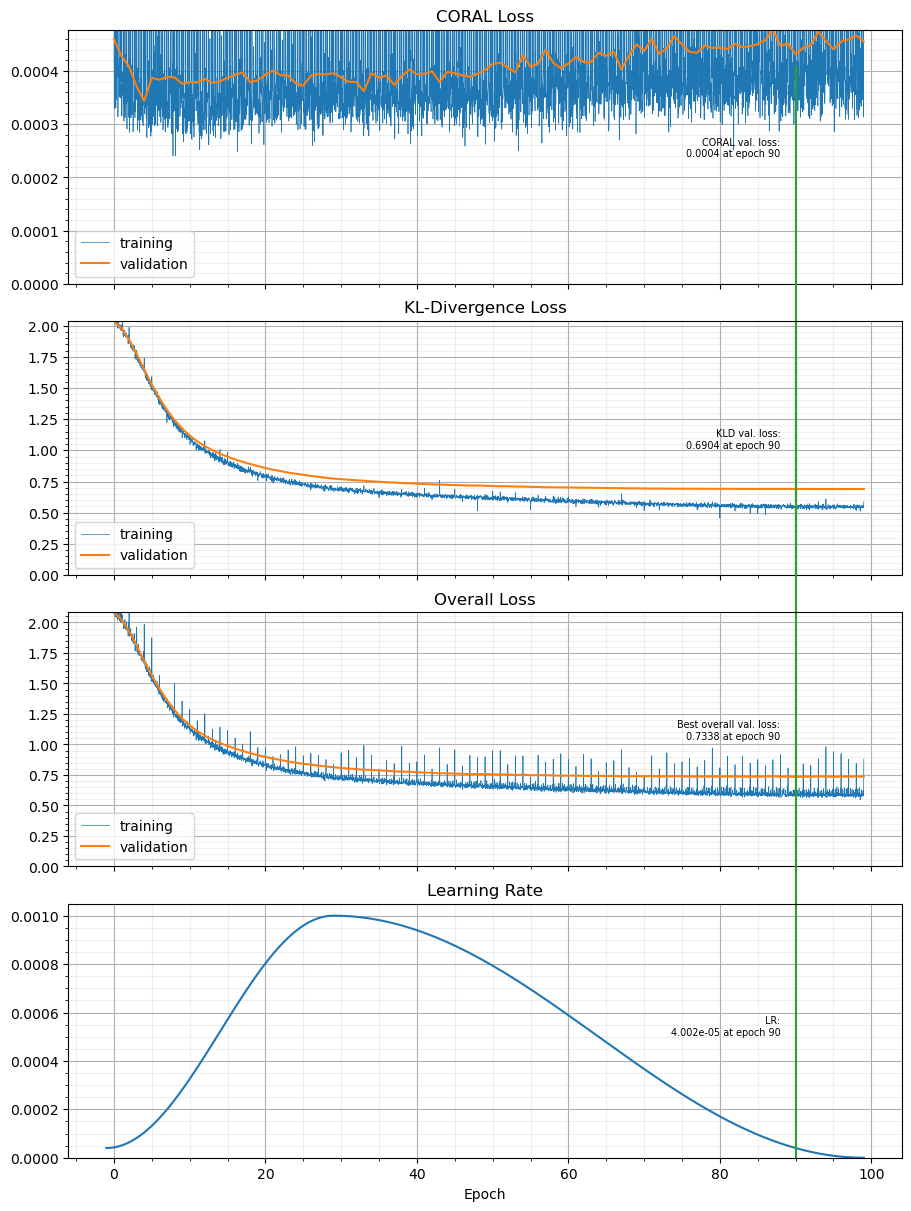

Adversarial training for ST slide 151508: 
CORAL(
  (encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout(p=0.5, inplace=False)
      (12): Linear(in_features=64, out_features=33, bias=True)
    )
  )
  (source_encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=T

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch || KLDiv.          || Coral           || Overall         || Next LR    
       || Train  | Val.   || Train  | Val.   || Train  | Val.   ||            
------------------------------------------------------------------------------
     0 || 3.5757 | 2.4477 || 0.0218 | 0.0005 || 5.6826 | 2.4955 || 4.2634e-05 <-- new best val loss
     1 || 2.4153 | 2.3503 || 0.0004 | 0.0004 || 2.4580 | 2.3912 || 5.0507e-05 <-- new best val loss
     2 || 2.2777 | 2.1866 || 0.0004 | 0.0004 || 2.3178 | 2.2258 || 6.3532e-05 <-- new best val loss
     3 || 2.0843 | 1.9809 || 0.0004 | 0.0004 || 2.1247 | 2.0251 || 8.1566e-05 <-- new best val loss
     4 || 1.8642 | 1.7687 || 0.0005 | 0.0005 || 1.9145 | 1.8206 || 0.00010441 <-- new best val loss
     5 || 1.6531 | 1.5766 || 0.0005 | 0.0005 || 1.7050 | 1.6253 || 0.00013182 <-- new best val loss
     6 || 1.4719 | 1.4224 || 0.0005 | 0.0005 || 1.5224 | 1.4714 || 0.00016349 <-- new best val loss
     7 || 1.3306 | 1.3070 || 0.0005 | 0.0005 || 1.3805 | 1.3543

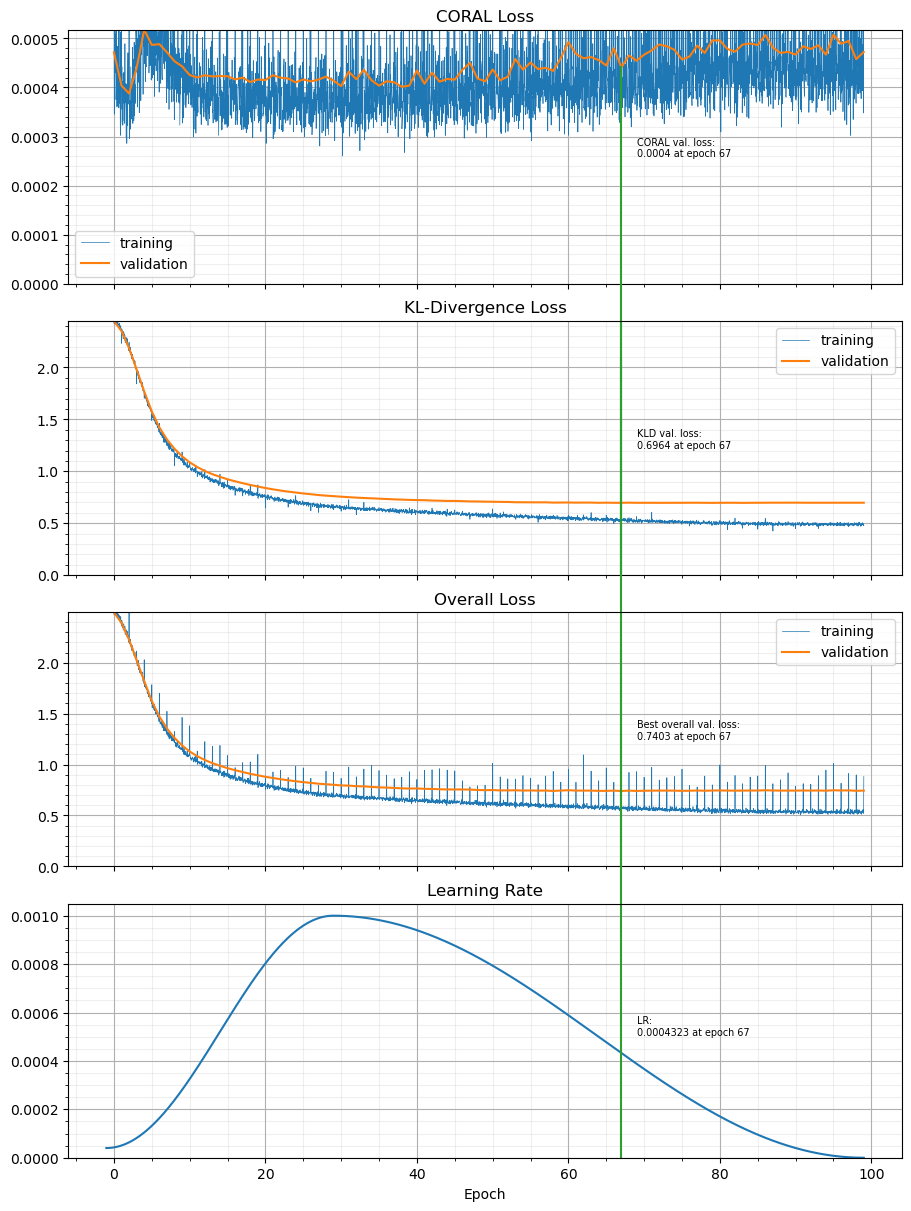

Adversarial training for ST slide 151509: 
CORAL(
  (encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout(p=0.5, inplace=False)
      (12): Linear(in_features=64, out_features=33, bias=True)
    )
  )
  (source_encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=T

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch || KLDiv.          || Coral           || Overall         || Next LR    
       || Train  | Val.   || Train  | Val.   || Train  | Val.   ||            
------------------------------------------------------------------------------
     0 || 3.5433 | 2.1800 || 0.0210 | 0.0005 || 5.6298 | 2.2266 || 4.2634e-05 <-- new best val loss
     1 || 2.1535 | 2.1067 || 0.0004 | 0.0004 || 2.1965 | 2.1505 || 5.0507e-05 <-- new best val loss
     2 || 2.0521 | 1.9854 || 0.0004 | 0.0005 || 2.0952 | 2.0312 || 6.3532e-05 <-- new best val loss
     3 || 1.9115 | 1.8351 || 0.0005 | 0.0005 || 1.9571 | 1.8837 || 8.1566e-05 <-- new best val loss
     4 || 1.7497 | 1.6766 || 0.0005 | 0.0005 || 1.7974 | 1.7310 || 0.00010441 <-- new best val loss
     5 || 1.5888 | 1.5269 || 0.0005 | 0.0005 || 1.6390 | 1.5807 || 0.00013182 <-- new best val loss
     6 || 1.4472 | 1.4016 || 0.0005 | 0.0005 || 1.4957 | 1.4527 || 0.00016349 <-- new best val loss
     7 || 1.3312 | 1.2996 || 0.0005 | 0.0004 || 1.3767 | 1.3448

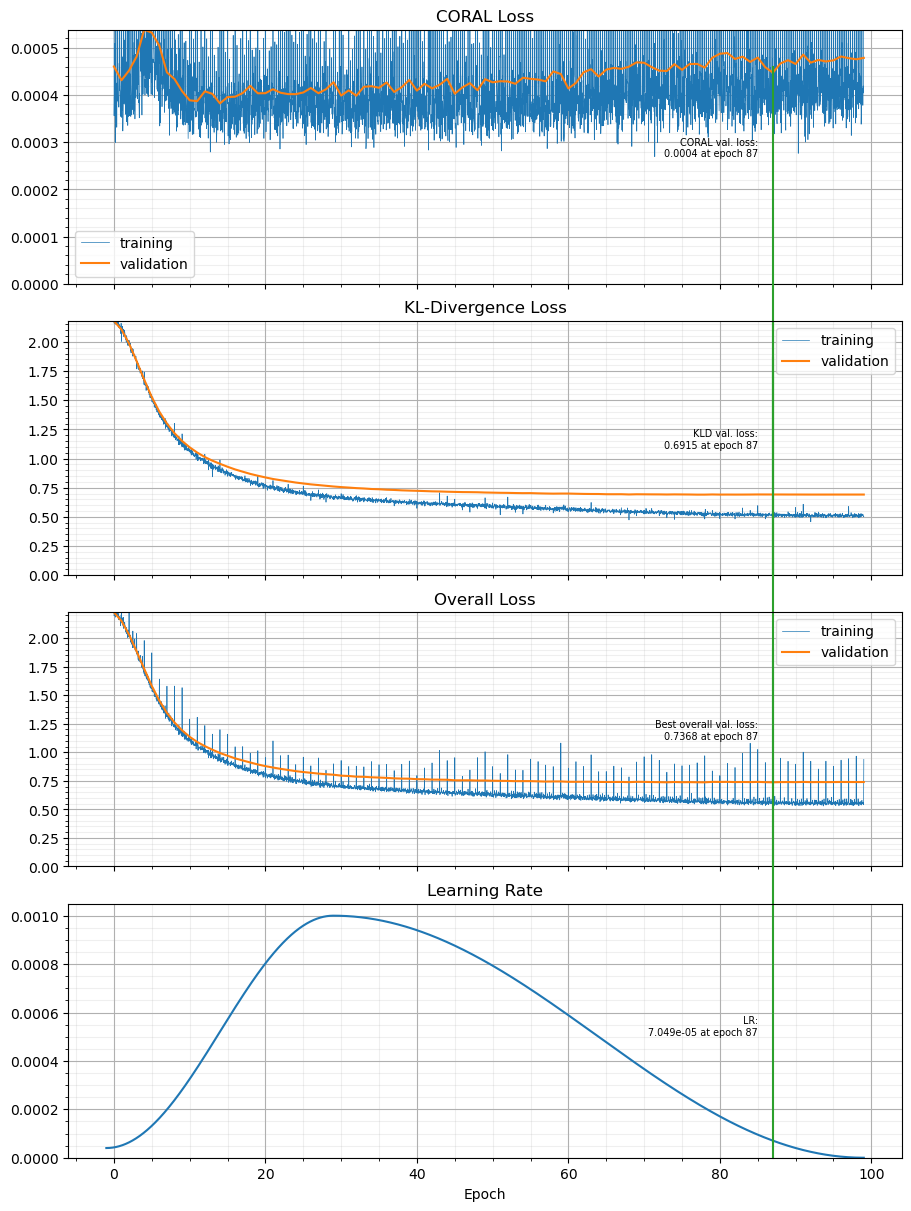

Adversarial training for ST slide 151510: 
CORAL(
  (encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout(p=0.5, inplace=False)
      (12): Linear(in_features=64, out_features=33, bias=True)
    )
  )
  (source_encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=T

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch || KLDiv.          || Coral           || Overall         || Next LR    
       || Train  | Val.   || Train  | Val.   || Train  | Val.   ||            
------------------------------------------------------------------------------
     0 || 3.5899 | 2.0546 || 0.0311 | 0.0008 || 7.0465 | 2.1438 || 4.2634e-05 <-- new best val loss
     1 || 2.0425 | 2.0213 || 0.0008 | 0.0007 || 2.1307 | 2.0953 || 5.0507e-05 <-- new best val loss
     2 || 1.9967 | 1.9661 || 0.0006 | 0.0007 || 2.0613 | 2.0443 || 6.3532e-05 <-- new best val loss
     3 || 1.9308 | 1.8926 || 0.0006 | 0.0005 || 1.9926 | 1.9429 || 8.1566e-05 <-- new best val loss
     4 || 1.8463 | 1.8019 || 0.0005 | 0.0005 || 1.8961 | 1.8517 || 0.00010441 <-- new best val loss
     5 || 1.7461 | 1.6993 || 0.0004 | 0.0005 || 1.7937 | 1.7502 || 0.00013182 <-- new best val loss
     6 || 1.6389 | 1.5940 || 0.0004 | 0.0004 || 1.6848 | 1.6369 || 0.00016349 <-- new best val loss
     7 || 1.5341 | 1.4947 || 0.0004 | 0.0003 || 1.5749 | 1.5302

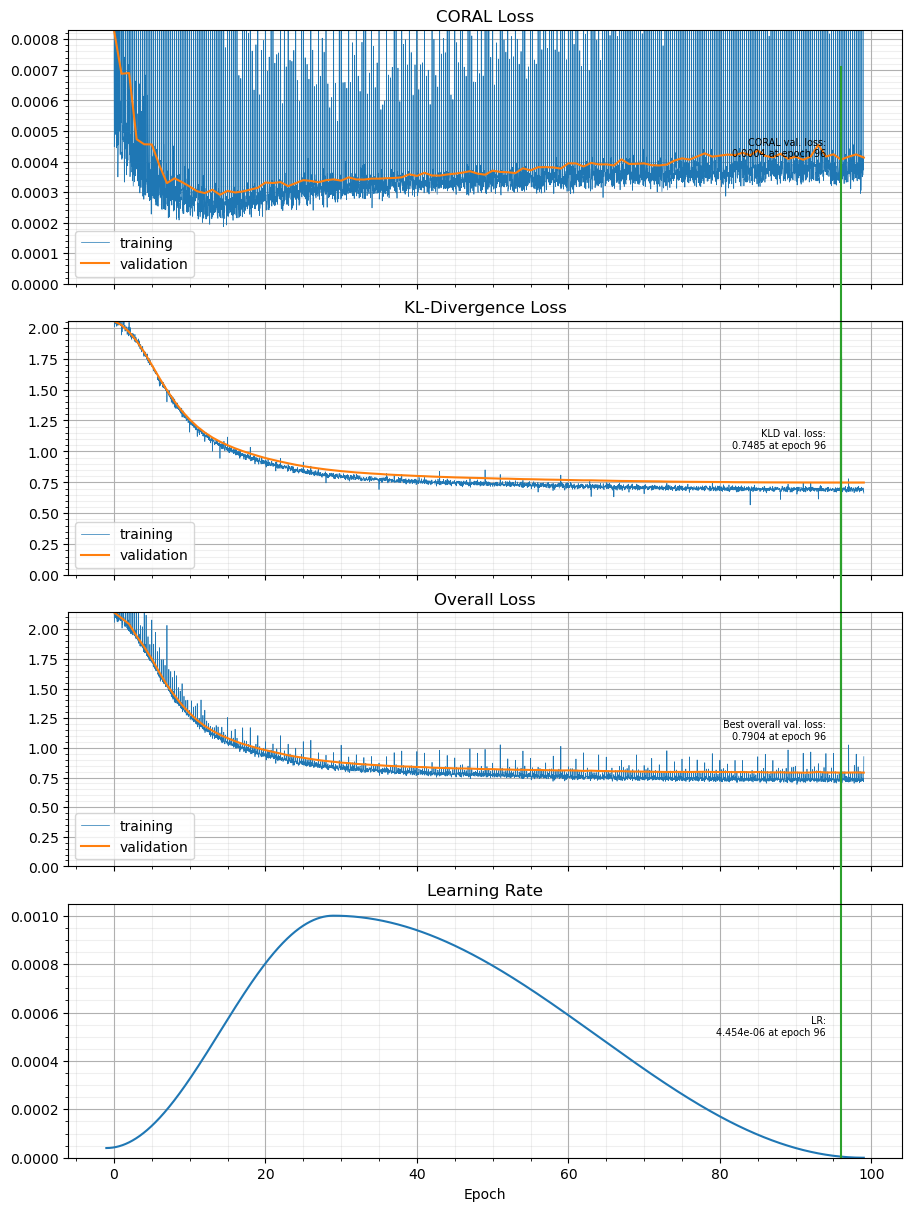

Adversarial training for ST slide 151669: 
CORAL(
  (encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout(p=0.5, inplace=False)
      (12): Linear(in_features=64, out_features=33, bias=True)
    )
  )
  (source_encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=T

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch || KLDiv.          || Coral           || Overall         || Next LR    
       || Train  | Val.   || Train  | Val.   || Train  | Val.   ||            
------------------------------------------------------------------------------
     0 || 3.5108 | 2.4064 || 0.0233 | 0.0005 || 5.9494 | 2.4648 || 4.2634e-05 <-- new best val loss
     1 || 2.3947 | 2.3353 || 0.0005 | 0.0005 || 2.4462 | 2.3847 || 5.0507e-05 <-- new best val loss
     2 || 2.2966 | 2.2175 || 0.0004 | 0.0004 || 2.3417 | 2.2625 || 6.3532e-05 <-- new best val loss
     3 || 2.1549 | 2.0594 || 0.0004 | 0.0004 || 2.2013 | 2.1061 || 8.1566e-05 <-- new best val loss
     4 || 1.9755 | 1.8710 || 0.0005 | 0.0005 || 2.0255 | 1.9283 || 0.00010441 <-- new best val loss
     5 || 1.7791 | 1.6809 || 0.0005 | 0.0006 || 1.8350 | 1.7417 || 0.00013182 <-- new best val loss
     6 || 1.5961 | 1.5171 || 0.0006 | 0.0006 || 1.6544 | 1.5756 || 0.00016349 <-- new best val loss
     7 || 1.4462 | 1.3892 || 0.0005 | 0.0006 || 1.5021 | 1.4480

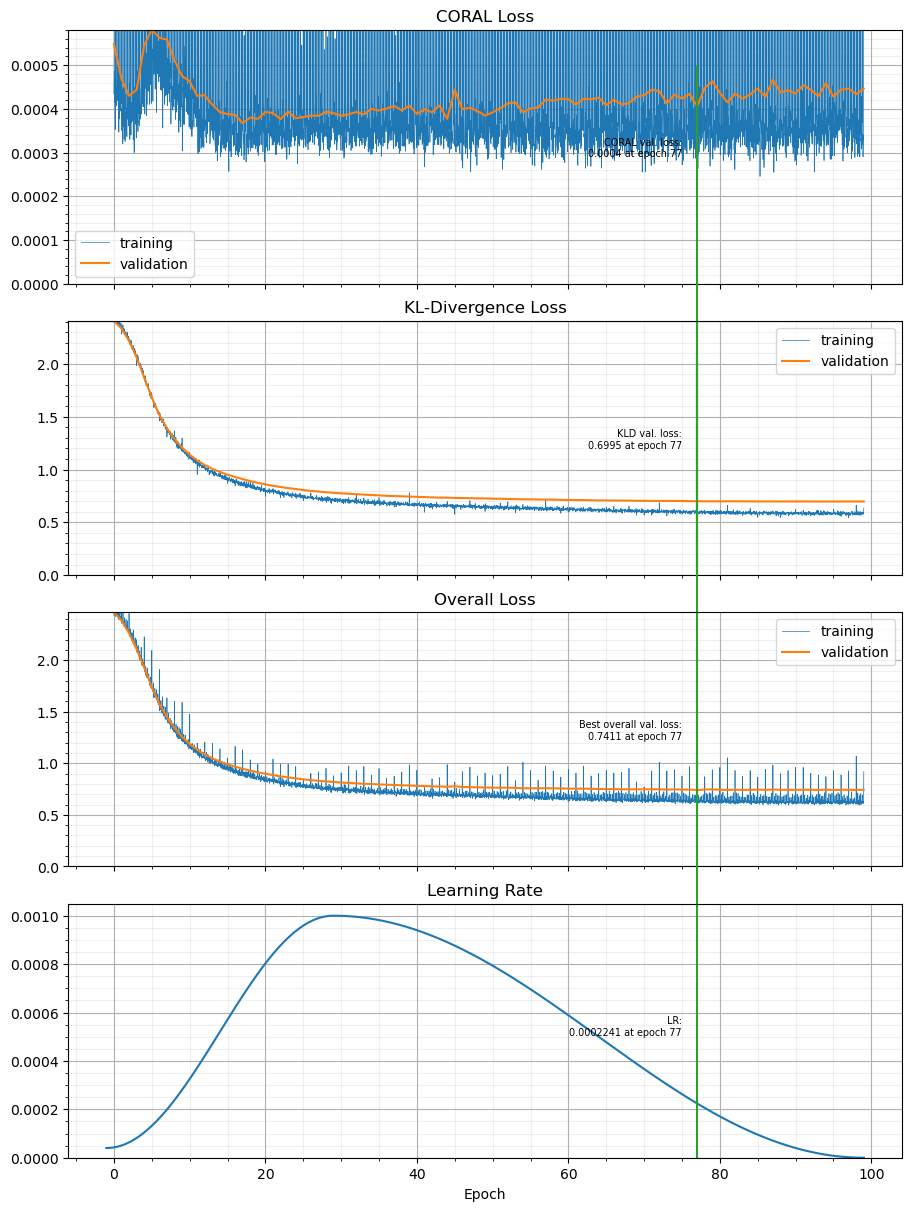

Adversarial training for ST slide 151670: 
CORAL(
  (encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout(p=0.5, inplace=False)
      (12): Linear(in_features=64, out_features=33, bias=True)
    )
  )
  (source_encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=T

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch || KLDiv.          || Coral           || Overall         || Next LR    
       || Train  | Val.   || Train  | Val.   || Train  | Val.   ||            
------------------------------------------------------------------------------
     0 || 3.5503 | 2.2126 || 0.0225 | 0.0005 || 5.7324 | 2.2630 || 4.2634e-05 <-- new best val loss
     1 || 2.1773 | 2.1255 || 0.0005 | 0.0005 || 2.2249 | 2.1726 || 5.0507e-05 <-- new best val loss
     2 || 2.0573 | 1.9839 || 0.0004 | 0.0004 || 2.1006 | 2.0274 || 6.3532e-05 <-- new best val loss
     3 || 1.8980 | 1.8199 || 0.0004 | 0.0005 || 1.9418 | 1.8671 || 8.1566e-05 <-- new best val loss
     4 || 1.7295 | 1.6578 || 0.0005 | 0.0005 || 1.7752 | 1.7040 || 0.00010441 <-- new best val loss
     5 || 1.5712 | 1.5108 || 0.0005 | 0.0005 || 1.6174 | 1.5608 || 0.00013182 <-- new best val loss
     6 || 1.4339 | 1.3901 || 0.0005 | 0.0005 || 1.4781 | 1.4360 || 0.00016349 <-- new best val loss
     7 || 1.3210 | 1.2933 || 0.0005 | 0.0005 || 1.3654 | 1.3394

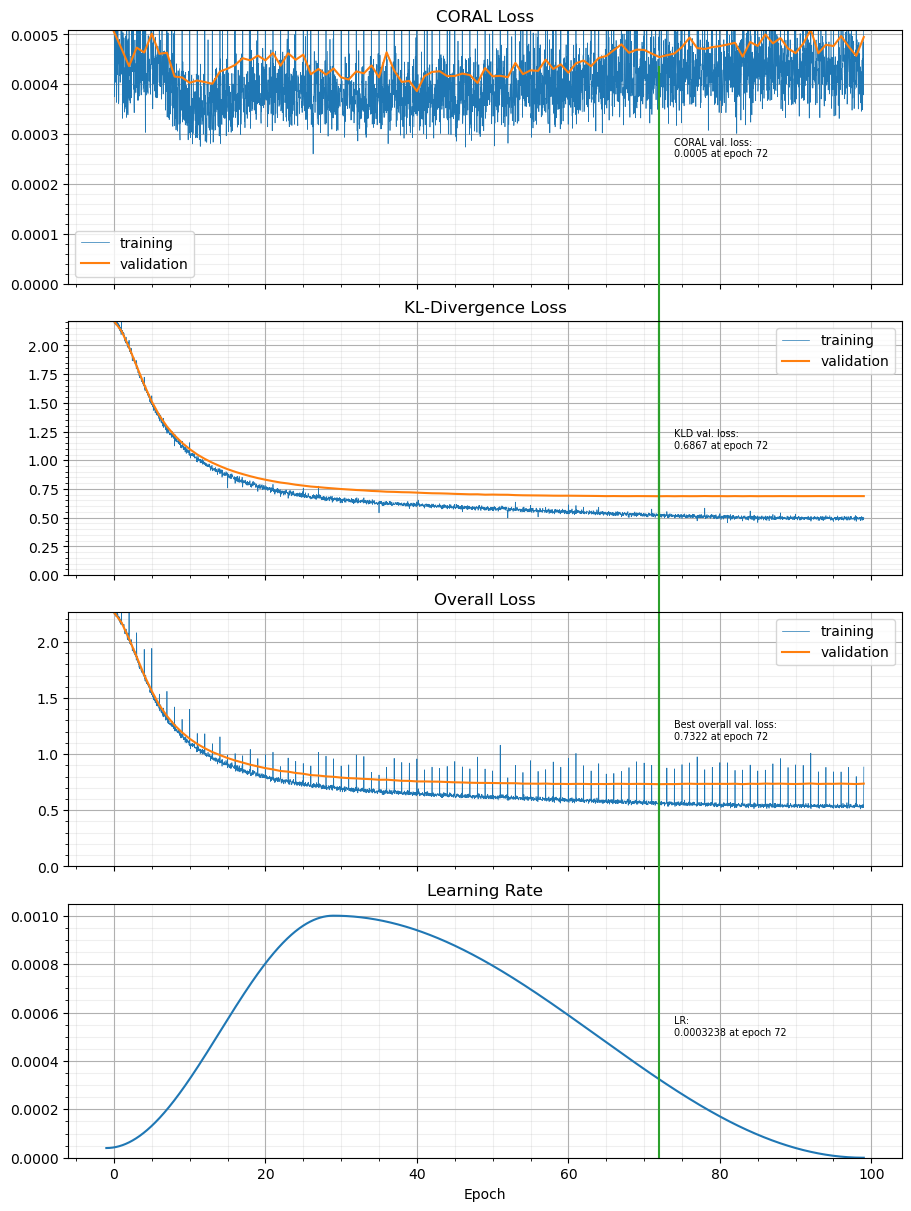

Adversarial training for ST slide 151671: 
CORAL(
  (encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout(p=0.5, inplace=False)
      (12): Linear(in_features=64, out_features=33, bias=True)
    )
  )
  (source_encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=T

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch || KLDiv.          || Coral           || Overall         || Next LR    
       || Train  | Val.   || Train  | Val.   || Train  | Val.   ||            
------------------------------------------------------------------------------
     0 || 3.6084 | 2.1290 || 0.0432 | 0.0008 || 8.7061 | 2.2188 || 4.2634e-05 <-- new best val loss
     1 || 2.1360 | 2.0992 || 0.0008 | 0.0008 || 2.2266 | 2.1899 || 5.0507e-05 <-- new best val loss
     2 || 2.0946 | 2.0488 || 0.0008 | 0.0008 || 2.1812 | 2.1421 || 6.3532e-05 <-- new best val loss
     3 || 2.0331 | 1.9793 || 0.0008 | 0.0008 || 2.1199 | 2.0788 || 8.1566e-05 <-- new best val loss
     4 || 1.9523 | 1.8911 || 0.0009 | 0.0008 || 2.0578 | 1.9863 || 0.00010441 <-- new best val loss
     5 || 1.8544 | 1.7899 || 0.0007 | 0.0007 || 1.9397 | 1.8735 || 0.00013182 <-- new best val loss
     6 || 1.7472 | 1.6841 || 0.0008 | 0.0006 || 1.8433 | 1.7558 || 0.00016349 <-- new best val loss
     7 || 1.6391 | 1.5809 || 0.0005 | 0.0005 || 1.6965 | 1.6400

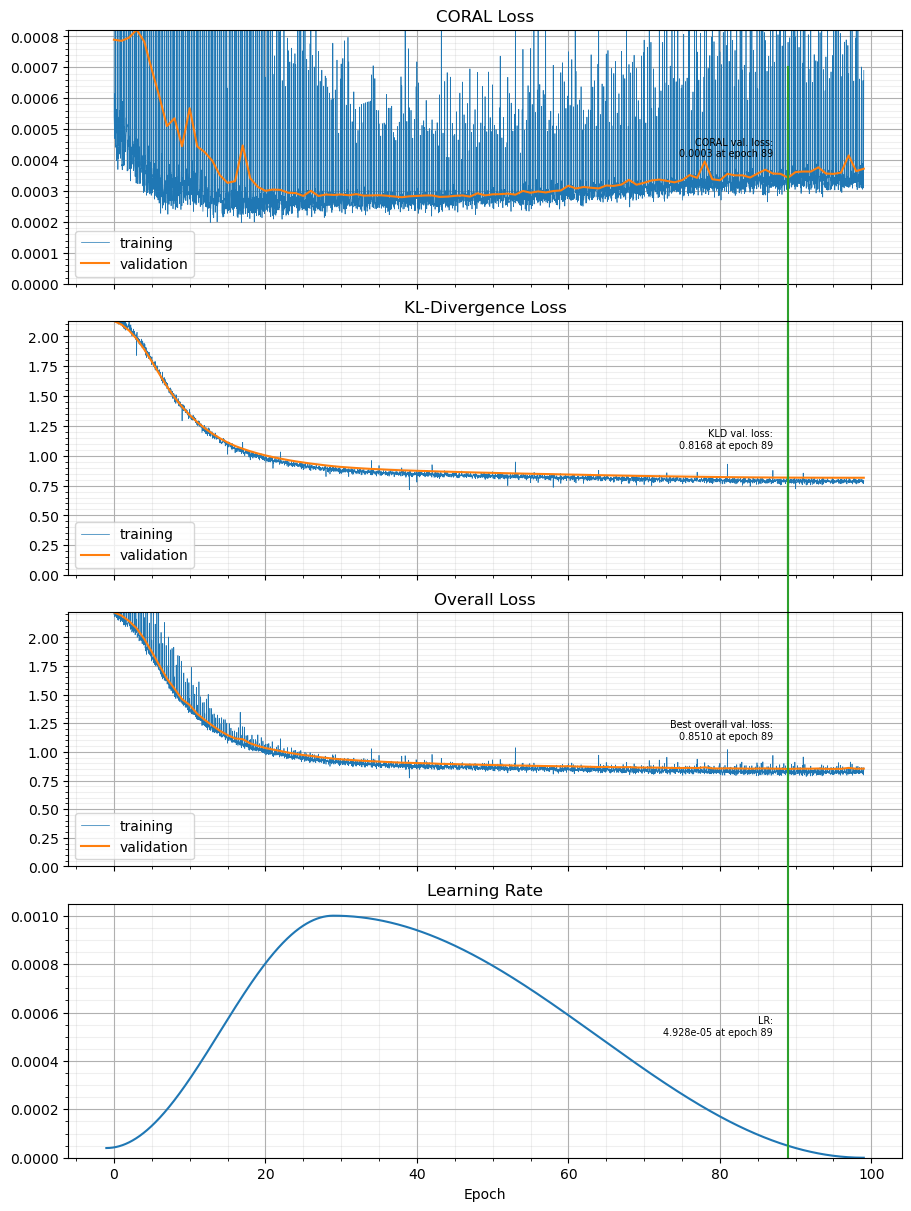

Adversarial training for ST slide 151672: 
CORAL(
  (encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout(p=0.5, inplace=False)
      (12): Linear(in_features=64, out_features=33, bias=True)
    )
  )
  (source_encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=T

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch || KLDiv.          || Coral           || Overall         || Next LR    
       || Train  | Val.   || Train  | Val.   || Train  | Val.   ||            
------------------------------------------------------------------------------
     0 || 3.5222 | 2.1341 || 0.0250 | 0.0006 || 5.9505 | 2.1899 || 4.2634e-05 <-- new best val loss
     1 || 2.1029 | 2.0654 || 0.0005 | 0.0005 || 2.1557 | 2.1133 || 5.0507e-05 <-- new best val loss
     2 || 2.0100 | 1.9549 || 0.0005 | 0.0004 || 2.0569 | 1.9997 || 6.3532e-05 <-- new best val loss
     3 || 1.8836 | 1.8198 || 0.0005 | 0.0005 || 1.9279 | 1.8655 || 8.1566e-05 <-- new best val loss
     4 || 1.7405 | 1.6773 || 0.0004 | 0.0004 || 1.7839 | 1.7216 || 0.00010441 <-- new best val loss
     5 || 1.5975 | 1.5403 || 0.0005 | 0.0004 || 1.6415 | 1.5831 || 0.00013182 <-- new best val loss
     6 || 1.4658 | 1.4204 || 0.0004 | 0.0004 || 1.5076 | 1.4625 || 0.00016349 <-- new best val loss
     7 || 1.3508 | 1.3197 || 0.0004 | 0.0004 || 1.3919 | 1.3607

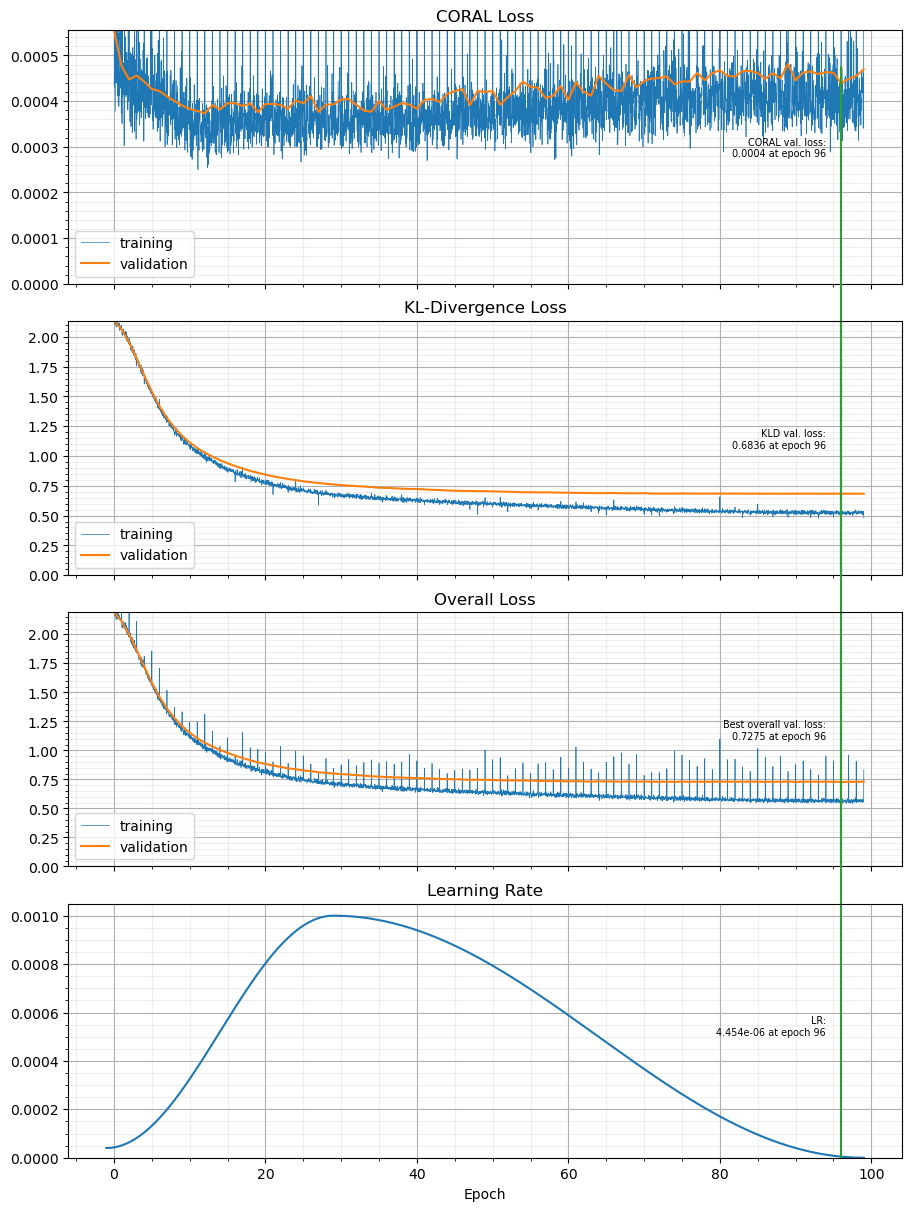

Adversarial training for ST slide 151673: 
CORAL(
  (encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout(p=0.5, inplace=False)
      (12): Linear(in_features=64, out_features=33, bias=True)
    )
  )
  (source_encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=T

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch || KLDiv.          || Coral           || Overall         || Next LR    
       || Train  | Val.   || Train  | Val.   || Train  | Val.   ||            
------------------------------------------------------------------------------
     0 || 3.5779 | 2.0993 || 0.0272 | 0.0005 || 6.4722 | 2.1550 || 4.2634e-05 <-- new best val loss
     1 || 2.0785 | 2.0423 || 0.0005 | 0.0005 || 2.1304 | 2.0935 || 5.0507e-05 <-- new best val loss
     2 || 1.9969 | 1.9428 || 0.0005 | 0.0005 || 2.0443 | 1.9940 || 6.3532e-05 <-- new best val loss
     3 || 1.8820 | 1.8206 || 0.0005 | 0.0004 || 1.9309 | 1.8656 || 8.1566e-05 <-- new best val loss
     4 || 1.7510 | 1.6908 || 0.0004 | 0.0004 || 1.7972 | 1.7363 || 0.00010441 <-- new best val loss
     5 || 1.6204 | 1.5691 || 0.0005 | 0.0004 || 1.6696 | 1.6161 || 0.00013182 <-- new best val loss
     6 || 1.5021 | 1.4603 || 0.0004 | 0.0004 || 1.5461 | 1.4994 || 0.00016349 <-- new best val loss
     7 || 1.3971 | 1.3626 || 0.0004 | 0.0004 || 1.4372 | 1.4019

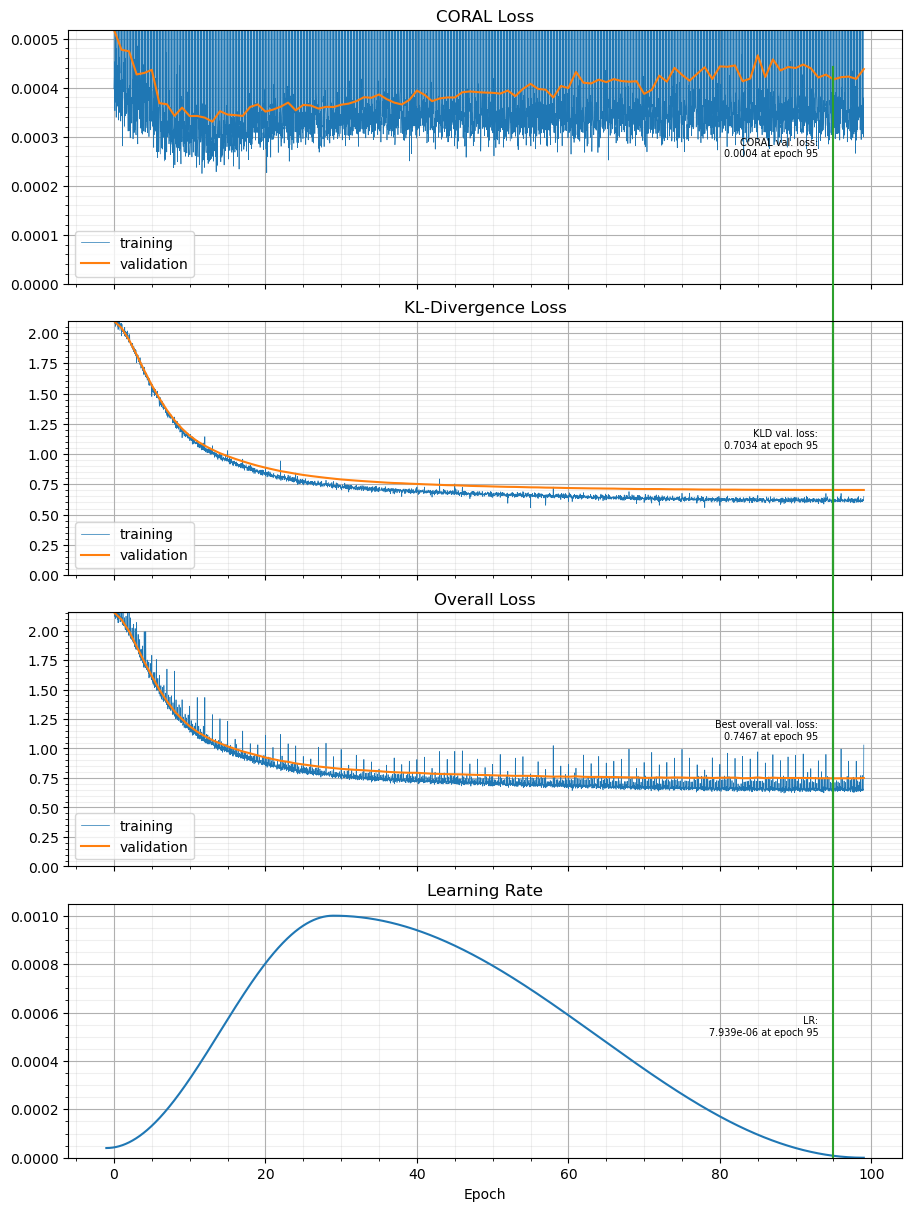

Adversarial training for ST slide 151674: 
CORAL(
  (encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout(p=0.5, inplace=False)
      (12): Linear(in_features=64, out_features=33, bias=True)
    )
  )
  (source_encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=T

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch || KLDiv.          || Coral           || Overall         || Next LR    
       || Train  | Val.   || Train  | Val.   || Train  | Val.   ||            
------------------------------------------------------------------------------
     0 || 3.5307 | 2.0147 || 0.0220 | 0.0005 || 5.7999 | 2.0639 || 4.2634e-05 <-- new best val loss
     1 || 2.0042 | 1.9630 || 0.0005 | 0.0004 || 2.0519 | 2.0083 || 5.0507e-05 <-- new best val loss
     2 || 1.9314 | 1.8775 || 0.0004 | 0.0004 || 1.9734 | 1.9211 || 6.3532e-05 <-- new best val loss
     3 || 1.8298 | 1.7695 || 0.0004 | 0.0004 || 1.8686 | 1.8119 || 8.1566e-05 <-- new best val loss
     4 || 1.7105 | 1.6507 || 0.0004 | 0.0004 || 1.7472 | 1.6881 || 0.00010441 <-- new best val loss
     5 || 1.5880 | 1.5352 || 0.0004 | 0.0004 || 1.6266 | 1.5776 || 0.00013182 <-- new best val loss
     6 || 1.4744 | 1.4312 || 0.0004 | 0.0004 || 1.5137 | 1.4704 || 0.00016349 <-- new best val loss
     7 || 1.3727 | 1.3373 || 0.0004 | 0.0004 || 1.4131 | 1.3758

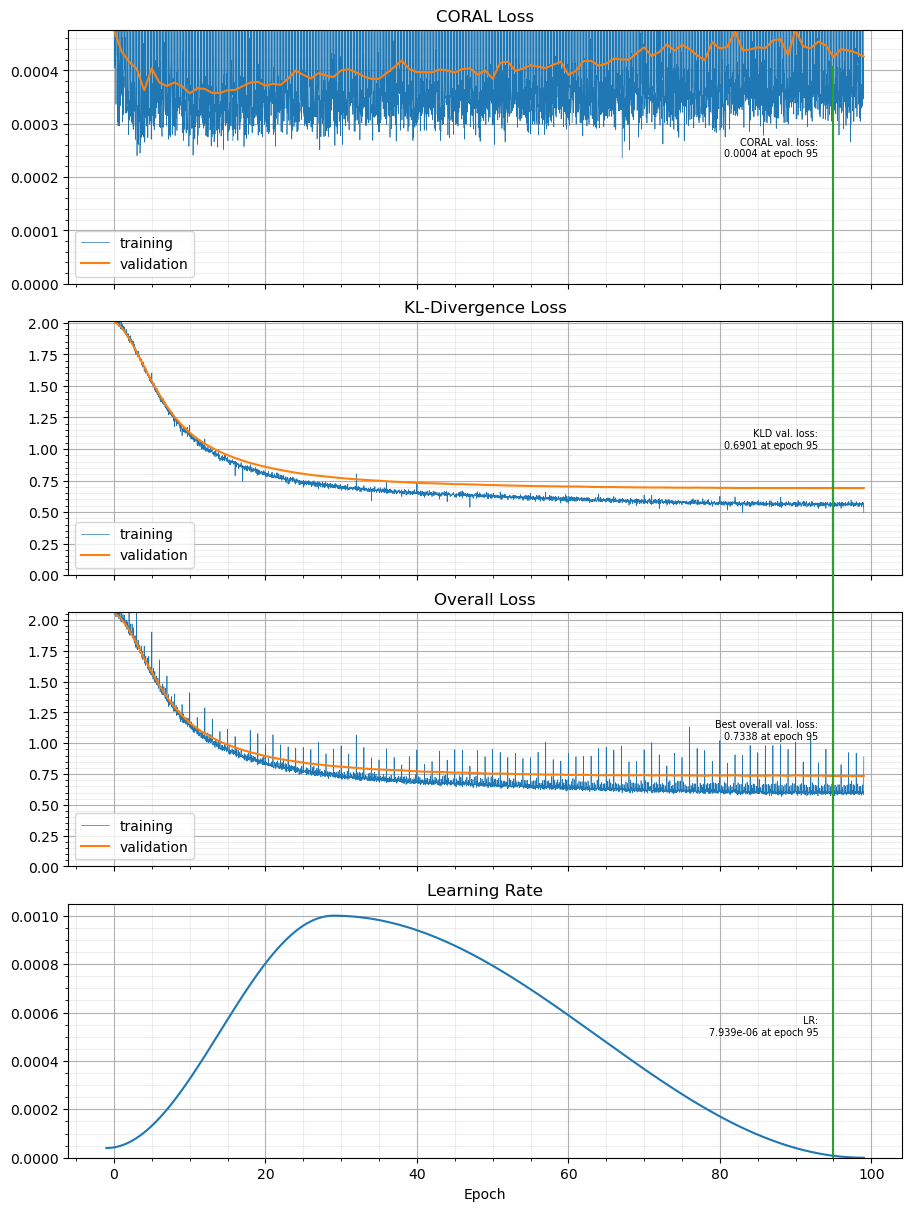

Adversarial training for ST slide 151675: 
CORAL(
  (encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout(p=0.5, inplace=False)
      (12): Linear(in_features=64, out_features=33, bias=True)
    )
  )
  (source_encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=T

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch || KLDiv.          || Coral           || Overall         || Next LR    
       || Train  | Val.   || Train  | Val.   || Train  | Val.   ||            
------------------------------------------------------------------------------
     0 || 3.5678 | 2.0303 || 0.0586 | 0.0011 || 11.1167 | 2.1759 || 4.2634e-05 <-- new best val loss
     1 || 2.0465 | 2.0191 || 0.0013 | 0.0014 || 2.2105 | 2.1959 || 5.0507e-05 
     2 || 2.0309 | 2.0000 || 0.0008 | 0.0016 || 2.1245 | 2.2133 || 6.3532e-05 
     3 || 2.0072 | 1.9727 || 0.0008 | 0.0015 || 2.1093 | 2.1730 || 8.1566e-05 <-- new best val loss
     4 || 1.9742 | 1.9356 || 0.0008 | 0.0008 || 2.0676 | 2.0291 || 0.00010441 <-- new best val loss
     5 || 1.9299 | 1.8867 || 0.0008 | 0.0010 || 2.0270 | 2.0109 || 0.00013182 <-- new best val loss
     6 || 1.8738 | 1.8271 || 0.0007 | 0.0007 || 1.9626 | 1.9104 || 0.00016349 <-- new best val loss
     7 || 1.8075 | 1.7588 || 0.0007 | 0.0006 || 1.9008 | 1.8306 || 0.00019907 <-- new best val loss
    

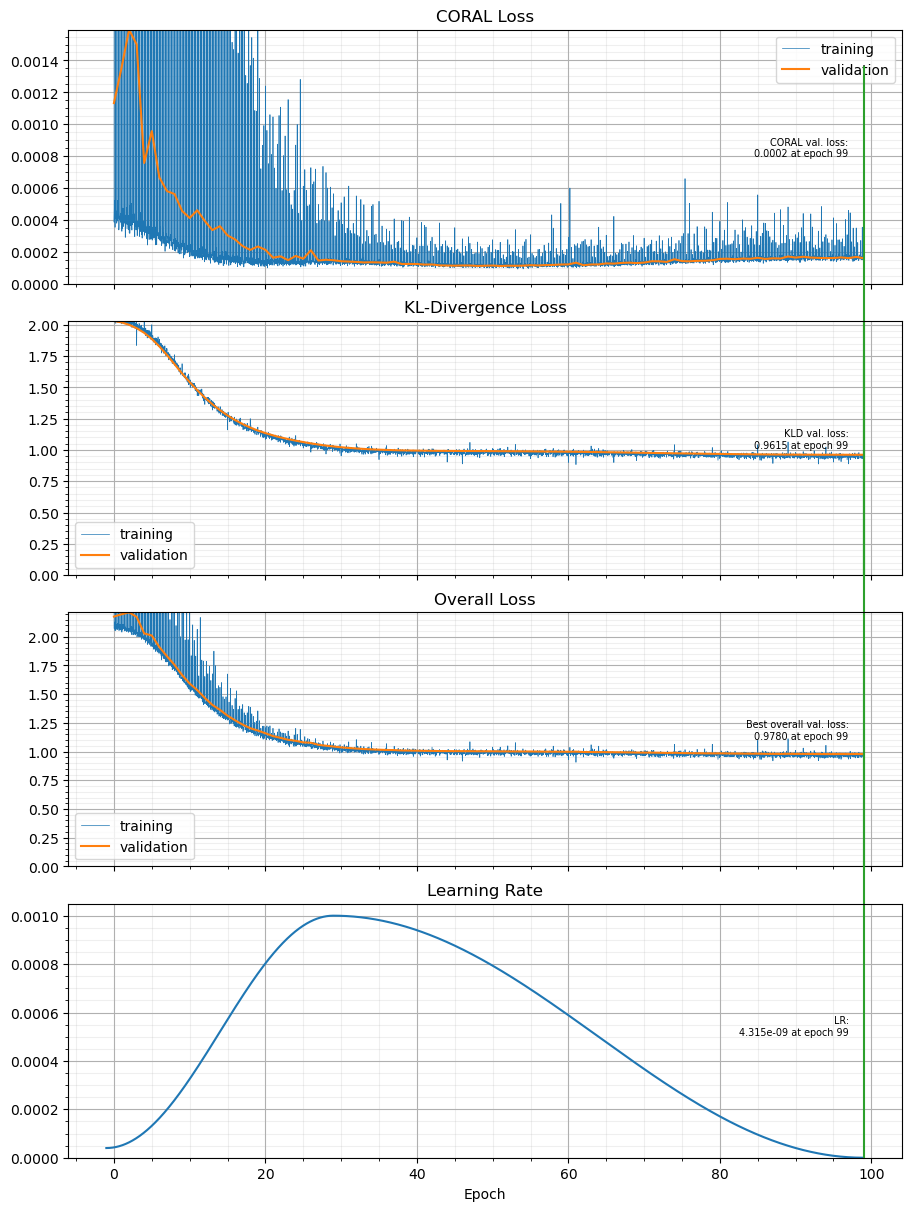

Adversarial training for ST slide 151676: 
CORAL(
  (encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout(p=0.5, inplace=False)
      (12): Linear(in_features=64, out_features=33, bias=True)
    )
  )
  (source_encoder): MLP(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=T

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

 Epoch || KLDiv.          || Coral           || Overall         || Next LR    
       || Train  | Val.   || Train  | Val.   || Train  | Val.   ||            
------------------------------------------------------------------------------
     0 || 3.5835 | 2.3630 || 0.0240 | 0.0004 || 5.9055 | 2.4042 || 4.2634e-05 <-- new best val loss
     1 || 2.3239 | 2.2808 || 0.0004 | 0.0004 || 2.3632 | 2.3170 || 5.0507e-05 <-- new best val loss
     2 || 2.2091 | 2.1438 || 0.0004 | 0.0003 || 2.2451 | 2.1769 || 6.3532e-05 <-- new best val loss
     3 || 2.0456 | 1.9658 || 0.0004 | 0.0004 || 2.0841 | 2.0042 || 8.1566e-05 <-- new best val loss
     4 || 1.8485 | 1.7661 || 0.0005 | 0.0004 || 1.8919 | 1.8095 || 0.00010441 <-- new best val loss
     5 || 1.6452 | 1.5701 || 0.0005 | 0.0004 || 1.6896 | 1.6124 || 0.00013182 <-- new best val loss
     6 || 1.4620 | 1.4063 || 0.0005 | 0.0004 || 1.5071 | 1.4491 || 0.00016349 <-- new best val loss
     7 || 1.3226 | 1.2905 || 0.0005 | 0.0005 || 1.3677 | 1.3364

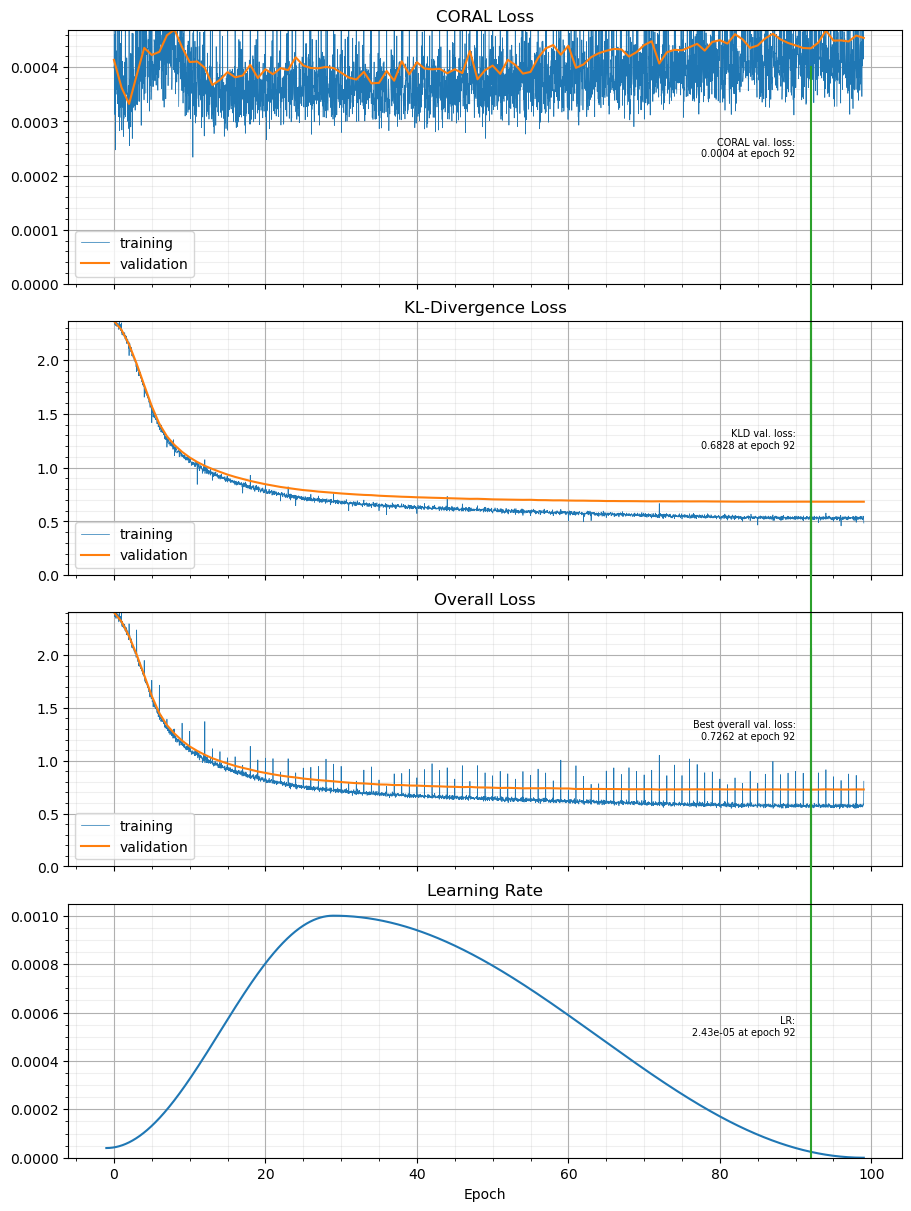

In [24]:
if data_params["train_using_all_st_samples"]:
    print(f"Adversarial training for all ST slides")
    save_folder = advtrain_folder

    model = CORAL(
        sc_mix_d["train"].shape[1],
        ncls_source=lab_mix_d["train"].shape[1],
        **model_params["coral_kwargs"],
    )
    model.apply(initialize_weights)
    if train_params.get("pretraining", False):
        best_pre_checkpoint = torch.load(
            os.path.join(pretrain_folder, f"final_model.pth")
        )
        model.load_state_dict(best_pre_checkpoint["model"].state_dict())
    model.to(device)

    model.advtraining()

    train_adversarial_iters(
        model,
        save_folder,
        dataloader_source_train,
        dataloader_source_val,
        dataloader_target_train,
    )

else:
    for sample_id in st_sample_id_l:
        print(f"Adversarial training for ST slide {sample_id}: ")

        save_folder = os.path.join(advtrain_folder, sample_id)
        if not os.path.isdir(save_folder):
            os.makedirs(save_folder)

        model = CORAL(
            sc_mix_d["train"].shape[1],
            ncls_source=lab_mix_d["train"].shape[1],
            **model_params["coral_kwargs"],
        )
        model.apply(initialize_weights)

        if train_params.get("pretraining", False):
            best_pre_checkpoint = torch.load(
                os.path.join(pretrain_folder, f"final_model.pth")
            )
            model.load_state_dict(best_pre_checkpoint["model"].state_dict())
        model.to(device)

        model.advtraining()

        print(model)
        results = train_adversarial_iters(
            model,
            save_folder,
            dataloader_source_train,
            dataloader_source_val,
            dataloader_target_train_d[sample_id],
        )
        plot_results(save_folder, results)


In [25]:
with open(os.path.join(model_folder, "config.yml"), "w") as f:
    yaml.safe_dump(config, f)


In [26]:
print(
    "Script run time:", datetime.datetime.now(datetime.timezone.utc) - script_start_time
)


Script run time: 1:11:26.838517


 ## Evaluation of latent space

In [27]:
# from sklearn.decomposition import PCA
# from sklearn import model_selection
# from sklearn.ensemble import RandomForestClassifier


# for sample_id in st_sample_id_l:
#     best_checkpoint = torch.load(
#         os.path.join(advtrain_folder, sample_id, f"final_model.pth")
#     )
#     model = best_checkpoint["model"]
#     model.to(device)

#     model.eval()
#     model.target_inference()

#     with torch.no_grad():
#         source_emb = model.source_encoder(torch.Tensor(sc_mix_train_s).to(device))
#         target_emb = model.target_encoder(
#             torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)
#         )

#         y_dis = torch.cat(
#             [
#                 torch.zeros(source_emb.shape[0], device=device, dtype=torch.long),
#                 torch.ones(target_emb.shape[0], device=device, dtype=torch.long),
#             ]
#         )

#         emb = torch.cat([source_emb, target_emb])

#         emb = emb.detach().cpu().numpy()
#         y_dis = y_dis.detach().cpu().numpy()

#     (emb_train, emb_test, y_dis_train, y_dis_test,) = model_selection.train_test_split(
#         emb,
#         y_dis,
#         test_size=0.2,
#         random_state=225,
#         stratify=y_dis,
#     )

#     pca = PCA(n_components=50)
#     pca.fit(emb_train)

#     emb_train_50 = pca.transform(emb_train)
#     emb_test_50 = pca.transform(emb_test)

#     clf = RandomForestClassifier(random_state=145, n_jobs=-1)
#     clf.fit(emb_train_50, y_dis_train)
#     accu_train = clf.score(emb_train_50, y_dis_train)
#     accu_test = clf.score(emb_test_50, y_dis_test)
#     class_proportions = np.mean(y_dis)

#     print(
#         "Training accuracy: {}, Test accuracy: {}, Class proportions: {}".format(
#             accu_train, accu_test, class_proportions
#         )
#     )


  # 4. Predict cell fraction of spots and visualization

In [28]:
# pred_sp_d, pred_sp_noda_d = {}, {}
# if TRAIN_USING_ALL_ST_SAMPLES:
#     best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
#     model = best_checkpoint["model"]
#     model.to(device)

#     model.eval()
#     model.target_inference()
#     with torch.no_grad():
#         for sample_id in st_sample_id_l:
#             pred_sp_d[sample_id] = (
#                 torch.exp(
#                     model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
#                 )
#                 .detach()
#                 .cpu()
#                 .numpy()
#             )

# else:
#     for sample_id in st_sample_id_l:
#         best_checkpoint = torch.load(
#             os.path.join(advtrain_folder, sample_id, f"final_model.pth")
#         )
#         model = best_checkpoint["model"]
#         model.to(device)

#         model.eval()
#         model.target_inference()

#         with torch.no_grad():
#             pred_sp_d[sample_id] = (
#                 torch.exp(
#                     model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
#                 )
#                 .detach()
#                 .cpu()
#                 .numpy()
#             )


# best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
# model = best_checkpoint["model"]
# model.to(device)

# model.eval()
# model.set_encoder("source")

# with torch.no_grad():
#     for sample_id in st_sample_id_l:
#         pred_sp_noda_d[sample_id] = (
#             torch.exp(model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)))
#             .detach()
#             .cpu()
#             .numpy()
#         )


In [29]:
# adata_spatialLIBD = sc.read_h5ad(
#     os.path.join(PROCESSED_DATA_DIR, "adata_spatialLIBD.h5ad")
# )

# adata_spatialLIBD_d = {}
# for sample_id in st_sample_id_l:
#     adata_spatialLIBD_d[sample_id] = adata_spatialLIBD[
#         adata_spatialLIBD.obs.sample_id == sample_id
#     ]
#     adata_spatialLIBD_d[sample_id].obsm["spatial"] = (
#         adata_spatialLIBD_d[sample_id].obs[["X", "Y"]].values
#     )


In [30]:
# num_name_exN_l = []
# for k, v in sc_sub_dict.items():
#     if "Ex" in v:
#         num_name_exN_l.append((k, v, int(v.split("_")[1])))
# num_name_exN_l.sort(key=lambda a: a[2])
# num_name_exN_l


In [31]:
# Ex_to_L_d = {
#     1: {5, 6},
#     2: {5},
#     3: {4, 5},
#     4: {6},
#     5: {5},
#     6: {4, 5, 6},
#     7: {4, 5, 6},
#     8: {5, 6},
#     9: {5, 6},
#     10: {2, 3, 4},
# }


In [32]:
# numlist = [t[0] for t in num_name_exN_l]
# Ex_l = [t[2] for t in num_name_exN_l]
# num_to_ex_d = dict(zip(numlist, Ex_l))


In [33]:
# def plot_cellfraction(visnum, adata, pred_sp, ax=None):
#     """Plot predicted cell fraction for a given visnum"""
#     adata.obs["Pred_label"] = pred_sp[:, visnum]
#     # vmin = 0
#     # vmax = np.amax(pred_sp)

#     sc.pl.spatial(
#         adata,
#         img_key="hires",
#         color="Pred_label",
#         palette="Set1",
#         size=1.5,
#         legend_loc=None,
#         title=f"{sc_sub_dict[visnum]}",
#         spot_size=100,
#         show=False,
#         # vmin=vmin,
#         # vmax=vmax,
#         ax=ax,
#     )


In [34]:
# def plot_roc(visnum, adata, pred_sp, name, ax=None):
#     """Plot ROC for a given visnum"""

#     def layer_to_layer_number(x):
#         for char in x:
#             if char.isdigit():
#                 if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
#                     return 1
#         return 0

#     y_pred = pred_sp[:, visnum]
#     y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)
#     # print(y_true)
#     # print(y_true.isna().sum())
#     RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)


In [35]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout=True)

# sc.pl.spatial(
#     adata_spatialLIBD_d[SAMPLE_ID_N],
#     img_key=None,
#     color="spatialLIBD",
#     palette="Accent_r",
#     size=1.5,
#     title=SAMPLE_ID_N,
#     # legend_loc = 4,
#     spot_size=100,
#     show=False,
#     ax=ax,
# )

# ax.axis("equal")
# ax.set_xlabel("")
# ax.set_ylabel("")

# fig.show()


In [36]:
# fig, ax = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

# for i, num in enumerate(numlist):
#     plot_cellfraction(
#         num, adata_spatialLIBD_d[SAMPLE_ID_N], pred_sp_d[SAMPLE_ID_N], ax.flat[i]
#     )
#     ax.flat[i].axis("equal")
#     ax.flat[i].set_xlabel("")
#     ax.flat[i].set_ylabel("")

# fig.show()

# fig, ax = plt.subplots(
#     2, 5, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True
# )

# for i, num in enumerate(numlist):
#     plot_roc(
#         num,
#         adata_spatialLIBD_d[SAMPLE_ID_N],
#         pred_sp_d[SAMPLE_ID_N],
#         "ADDA",
#         ax.flat[i],
#     )
#     plot_roc(
#         num,
#         adata_spatialLIBD_d[SAMPLE_ID_N],
#         pred_sp_noda_d[SAMPLE_ID_N],
#         "NN_wo_da",
#         ax.flat[i],
#     )
#     ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls="--", color="k")
#     ax.flat[i].set_aspect("equal")
#     ax.flat[i].set_xlim([0, 1])
#     ax.flat[i].set_ylim([0, 1])

#     ax.flat[i].set_title(f"{sc_sub_dict[num]}")

#     if i >= len(numlist) - 5:
#         ax.flat[i].set_xlabel("FPR")
#     else:
#         ax.flat[i].set_xlabel("")
#     if i % 5 == 0:
#         ax.flat[i].set_ylabel("TPR")
#     else:
#         ax.flat[i].set_ylabel("")

# fig.show()


In [37]:
# if TRAIN_USING_ALL_ST_SAMPLES:
#     best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
# else:
#     best_checkpoint = torch.load(
#         os.path.join(advtrain_folder, SAMPLE_ID_N, f"final_model.pth")
#     )

# model = best_checkpoint["model"]
# model.to(device)

# model.eval()
# model.set_encoder("source")

# with torch.no_grad():
#     pred_mix = (
#         torch.exp(model(torch.Tensor(sc_mix_test_s).to(device)))
#         .detach()
#         .cpu()
#         .numpy()
#     )

# cell_type_nums = sc_sub_dict.keys()
# nrows = ceil(len(cell_type_nums) / 5)

# line_kws = {"color": "tab:orange"}
# scatter_kws = {"s": 5}

# props = dict(facecolor="w", alpha=0.5)

# fig, ax = plt.subplots(
#     nrows,
#     5,
#     figsize=(25, 5 * nrows),
#     constrained_layout=True,
#     sharex=False,
#     sharey=True,
# )
# for i, visnum in enumerate(cell_type_nums):
#     sns.regplot(
#         x=pred_mix[:, visnum],
#         y=lab_mix_test[:, visnum],
#         line_kws=line_kws,
#         scatter_kws=scatter_kws,
#         ax=ax.flat[i],
#     ).set_title(sc_sub_dict[visnum])

#     ax.flat[i].set_aspect("equal")
#     ax.flat[i].set_xlabel("Predicted Proportion")

#     if i % 5 == 0:
#         ax.flat[i].set_ylabel("True Proportion")
#     else:
#         ax.flat[i].set_ylabel("")
#     ax.flat[i].set_xlim([0, 1])
#     ax.flat[i].set_ylim([0, 1])

#     textstr = (
#         f"MSE: {mean_squared_error(pred_mix[:,visnum], lab_mix_test[:,visnum]):.5f}"
#     )

#     # place a text box in upper left in axes coords
#     ax.flat[i].text(
#         0.95,
#         0.05,
#         textstr,
#         transform=ax.flat[i].transAxes,
#         verticalalignment="bottom",
#         horizontalalignment="right",
#         bbox=props,
#     )

# for i in range(len(cell_type_nums), nrows * 5):
#     ax.flat[i].axis("off")

# plt.show()
